# Laboratory work #1

## Downloading Dataset
Our dataset is FakeNews in Spanish (from [kaggle](https://www.kaggle.com/datasets/guillermoezquer/fakenews-espaol))

### Import all needed libraries.

In [1]:
# Importing text preprocessing libraries
import re
import nltk
from nltk.corpus import stopwords
import string
import spacy

# Importing models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Importing libraries for visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as gro

# Importing other libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

In [2]:
# Download nltk stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Who\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!python -m spacy download es_core_news_md

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/42.3 MB 2.2 MB/s eta 0:00:20
     ---------------------------------------- 0.4/42.3 MB 4.0 MB/s eta 0:00:11
      --------------------------------------- 0.8/42.3 MB 5.6 MB/s eta 0:00:08
      --------------------------------------- 1.0/42.3 MB 6.2 MB/s eta 0:00:07
     - -------------------------------------- 1.5/42.3 MB 6.8 MB/s eta 0:00:07
     - -------------------------------------- 1.8/42.3 MB 6.5 MB/s eta 0:00:07
     -- ------------------------------------- 2.1/42.3 MB 6.5 MB/s eta 0:00:07
     -- ------------------------------------- 2.8/42.3 MB 7.3 MB/s eta 0:00:06
     --- ------------------------------------ 3.3/42.3 MB 7.7 MB/s eta 0:00:06
     --- ------------------------------------ 3.8/42.3 MB 8.0 MB/s eta 0:00:05
     ---- ----------------------------------- 4.3/42.3 MB 8.0 MB/s eta 0:00:05
     ---- ----------------------------------- 4.7/42.3 MB 8


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
tqdm.pandas(desc="progress-bar")

## Preparatory stage

In [4]:
# Define path to dataset
path_to_dataset = Path("../input/dataset/fakenews.txt")

In [5]:
# Download dataset
fake_news_df = pd.read_csv(path_to_dataset, sep="\t", encoding="latin1")

In [6]:
# View first 5 rows
fake_news_df.head()

,Class,Text
0,True,Algunas de las voces extremistas más conocidas...
1,True,Después de casi dos años y medio de luchas pol...
2,True,Dos periodistas birmanos de la agencia Reuters...
3,True,El Cuerpo Nacional de Policía ha detenido a cu...
4,True,El desfile de la firma en Roma se convierte en...


In [8]:
# View size of dataset
fake_news_df.shape

(3568, 2)

In [9]:
# Drop NA values
fake_news_df.dropna(inplace=True)

In [10]:
# View info about dataset
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3568 non-null   bool  
 1   Text    3568 non-null   object
dtypes: bool(1), object(1)
memory usage: 31.5+ KB


In [11]:
# View classes in dataset
set(fake_news_df["Class"])

{False, True}

In [12]:
# Change class to 0 or 1
classes_dict = {True: 1, False: 0}
fake_news_df["Class"] = fake_news_df["Class"].apply(lambda x: classes_dict[x])

In [13]:
# Again view classes in dataset
set(fake_news_df["Class"])

{0, 1}

In [14]:
# View first 5 rows of fake news of dataset
fake_news_df[fake_news_df["Class"] == 1].head()

,Class,Text
0,1,Algunas de las voces extremistas más conocidas...
1,1,Después de casi dos años y medio de luchas pol...
2,1,Dos periodistas birmanos de la agencia Reuters...
3,1,El Cuerpo Nacional de Policía ha detenido a cu...
4,1,El desfile de la firma en Roma se convierte en...


In [15]:
# View first 5 rows of not fake news of dataset
fake_news_df[fake_news_df["Class"] == 0].head()

,Class,Text
9,0,El suceso ha tenido lugar en Brasil. Un adoles...
12,0,Estamos en la semana decisiva. Los expertos as...
13,0,Estudios científicos hay muchos. Unos nos inte...
16,0,Ha sucedido en la ciudad de San José de Río Pr...
17,0,La fiesta en Sevilla por el vuelco electoral s...


### Check length of text data in dataset

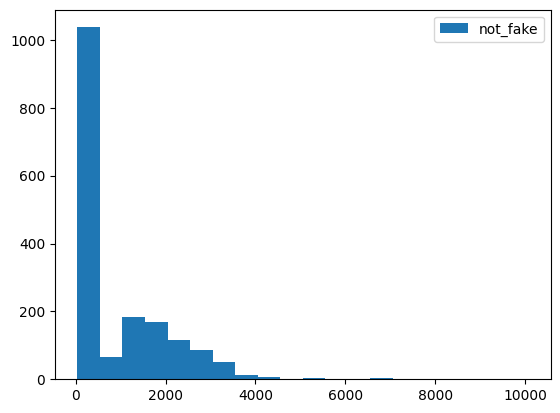

In [14]:
# Show quantity of the data in the dataset of not fake text
plt.hist(fake_news_df.loc[fake_news_df["Class"] == 0, "Text"].str.len(), bins=20, label="not_fake")
plt.legend()
plt.show()

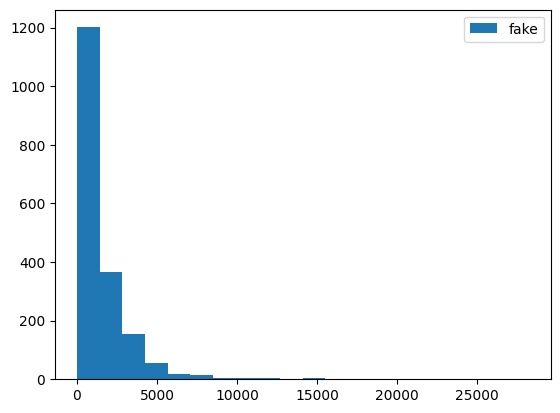

In [15]:
# Show quantity of the data in the dataset of fake text
plt.hist(fake_news_df.loc[fake_news_df["Class"] == 1, "Text"].str.len(), bins=20, label="fake")
plt.legend()
plt.show()

### Clean dataset from outliers

In [16]:
def clean_outliers(dataframe):
    """
    Function to clean dataset from the outliers;
    :param dataframe: pandas DataFrame with data;
    :return: new cleaned pandas DataFrame.
    """
    # Copy dataframe
    df_copy = dataframe.copy()

    # Calculate q1, q3 and iqr
    df_text_lens = dataframe["Text"].str.len()
    q1 = df_text_lens.quantile(0.25)
    q3 = df_text_lens.quantile(0.75)
    iqr = q3 - q1

    # Get local minimum and maximum
    local_min = q1 - (1.5 * iqr)
    local_max = q3 + (1.5 * iqr)
    if local_min < 0: local_min = 0

    # Remove the outliers
    df_copy = df_copy[(df_copy["Text"].str.len() >= local_min) &
                      (df_copy["Text"].str.len() <= local_max)]

    return df_copy

In [17]:
# Clean dataset from outliers
no_outliers_fake_news_df = clean_outliers(fake_news_df)

In [18]:
# View size of dataset
no_outliers_fake_news_df.shape

(3428, 2)

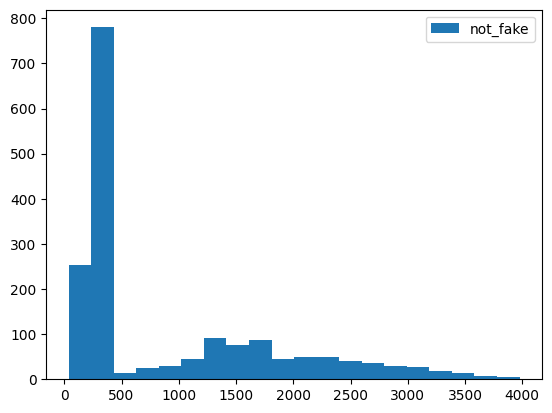

In [17]:
# Show quantity of the data in the dataset of not fake text
plt.hist(no_outliers_fake_news_df.loc[no_outliers_fake_news_df["Class"] == 0, "Text"].str.len(), bins=20, label="not_fake")
# plt.hist(fake_news_df.loc[fake_news_df["Class"] == 1, "Text"].str.len(), bins=20, label="fake")
plt.legend()
plt.show()

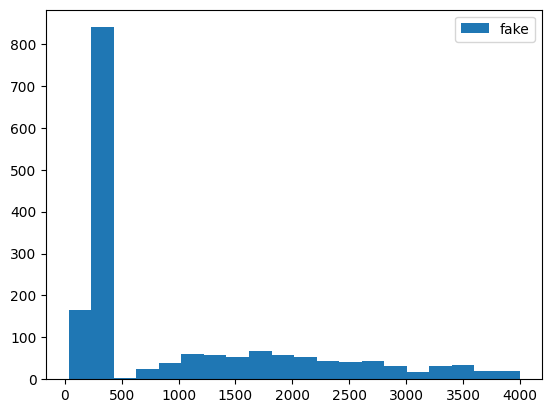

In [18]:
# Show quantity of the data in the dataset of fake text
plt.hist(no_outliers_fake_news_df.loc[no_outliers_fake_news_df["Class"] == 1, "Text"].str.len(),
         bins=20, label="fake")
plt.legend()
plt.show()

### Clean text

In [19]:
def cleaning_text(text_series, lower_case=True):
    """
    Help function for cleaning text string in pandas DataFrame;
    :param text_series: pandas Series with string text data;
    :param lower_case: bool for whether to reduce the text case or not;
    :return: pandas Series with some changes in string cell.
    """
    # Set stopwords
    spanish_stopw = stopwords.words("spanish")
    # Make cleaning
    if lower_case:
        text_series = text_series.str.lower()
    text_series = text_series.str.replace(r"\d", '')
    text_series = text_series.str.replace(r"[%s]" % re.escape(string.punctuation), '')
    text_series = text_series.str.replace(r"\n", '')
    text_series = text_series.str.replace(r"\s{2,}", ' ')
    # Remove Stop Words
    stp_wrds_str = r"\b(?:{})\b".format("|".join(spanish_stopw))
    text_series = text_series.str.replace(stp_wrds_str, '')
    text_series = text_series.str.replace(r"\s+", ' ')

    return text_series

In [20]:
# Clean text in dataset
clean_fake_news_df = no_outliers_fake_news_df.copy()
clean_fake_news_df["Text"] = cleaning_text(clean_fake_news_df["Text"])

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:13: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:15: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:19: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:20: FutureWarning:

The default value of regex will change from True to False in a future version.



In [21]:
# Check shape of data frame
clean_fake_news_df.shape

(3428, 2)

In [22]:
# View some samples
clean_fake_news_df.head()

,Class,Text
0,1,voces extremistas conocidas eeuu cuentas asoc...
1,1,después casi dos años medio luchas políticas j...
2,1,dos periodistas birmanos agencia reuters liber...
3,1,cuerpo nacional policía detenido cuatro perso...
4,1,desfile firma roma convierte oda libertad muj...


### View WordCloud for our fake data

In [35]:
# Define Fake and not Fake DataFrame
not_fake_df = clean_fake_news_df.loc[clean_fake_news_df["Class"] == 0]
fake_df = clean_fake_news_df.loc[clean_fake_news_df["Class"] == 1]

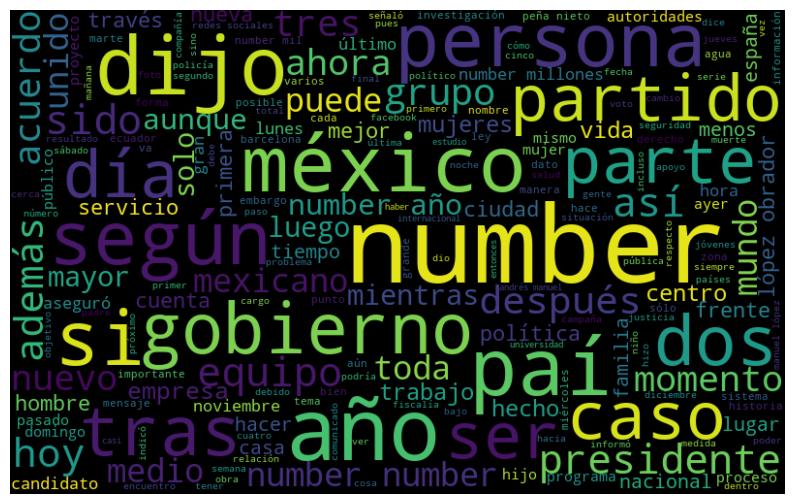

In [36]:
# Put all words to one string from fake dataframe
all_words = ' '.join([text for text in fake_df["Text"]])
# Define WordCloud for fake dataframe
wordcloud = WordCloud(width=800, height=500, random_state=17, max_font_size=110).generate(all_words)
# View wordcloud in plot
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### View WordCloud for our not fake data

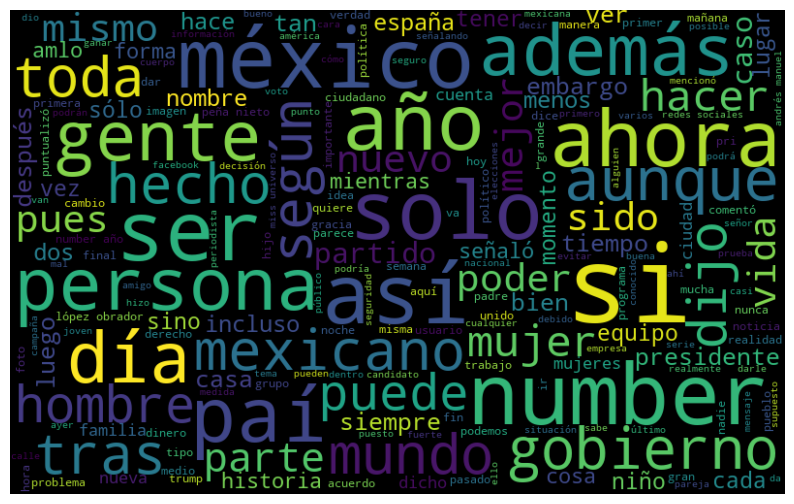

In [37]:
# Put all words to one string from fake dataframe
all_words = ' '.join([text for text in not_fake_df["Text"]])
# Define WordCloud for fake dataframe
wordcloud = WordCloud(width=800, height=500, random_state=17, max_font_size=110).generate(all_words)
# View wordcloud in plot
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Model realisation

### Stage 1: Feature extraction

#### Bag of Words

In [25]:
# Define Bag of Words vectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)
# Define Bag of Words model through fitting vectorizer on text data
bow = bow_vectorizer.fit_transform(clean_fake_news_df["Text"])

In [26]:
# View shape of BOW model
bow.shape

(3428, 1000)

In [27]:
# View on BOW model
bow

<3428x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 90609 stored elements in Compressed Sparse Row format>

In [28]:
# View some samples
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
# View the features list
bow_vectorizer.get_feature_names_out()

array(['abril', 'acceso', 'acciones', 'acción', 'actividad',
       'actividades', 'acto', 'actor', 'actos', 'actriz', 'actual',
       'actualmente', 'acuerdo', 'adelante', 'además', 'administración',
       'aeropuerto', 'afirma', 'afirmó', 'agencia', 'agentes', 'agosto',
       'agregó', 'agua', 'ahora', 'ahí', 'alcalde', 'alejandro',
       'alemania', 'alguien', 'alguna', 'algún', 'allá', 'allí',
       'alrededor', 'alta', 'alto', 'ambos', 'amigos', 'amlo', 'amor',
       'américa', 'anaya', 'andrés', 'angélica', 'animales', 'anterior',
       'antonio', 'anunciado', 'anunció', 'apenas', 'aplicación', 'apoyo',
       'aquí', 'argentina', 'argentino', 'artículo', 'asamblea',
       'asegura', 'aseguran', 'aseguró', 'asimismo', 'asociación', 'así',
       'ataque', 'atención', 'audiencia', 'aumento', 'aunque',
       'autoridades', 'avión', 'ayer', 'ayuda', 'ayudar', 'ayuntamiento',
       'azteca', 'azul', 'añadió', 'año', 'años', 'aún', 'baja', 'bajo',
       'banco', 'bandera', 

#### TFIDF

In [23]:
# Define TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)
# Define TFIDF model through fitting vectorizer on text data
tfidf = tfidf_vectorizer.fit_transform(clean_fake_news_df["Text"].tolist())

In [22]:
# View shape of TFIDF model
tfidf.shape

(3428, 1000)

In [23]:
# View TFIDF model
tfidf

<3428x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 90609 stored elements in Compressed Sparse Row format>

In [24]:
# View on features list
tfidf_vectorizer.get_feature_names_out()

array(['abril', 'acceso', 'acciones', 'acción', 'actividad',
       'actividades', 'acto', 'actor', 'actos', 'actriz', 'actual',
       'actualmente', 'acuerdo', 'adelante', 'además', 'administración',
       'aeropuerto', 'afirma', 'afirmó', 'agencia', 'agentes', 'agosto',
       'agregó', 'agua', 'ahora', 'ahí', 'alcalde', 'alejandro',
       'alemania', 'alguien', 'alguna', 'algún', 'allá', 'allí',
       'alrededor', 'alta', 'alto', 'ambos', 'amigos', 'amlo', 'amor',
       'américa', 'anaya', 'andrés', 'angélica', 'animales', 'anterior',
       'antonio', 'anunciado', 'anunció', 'apenas', 'aplicación', 'apoyo',
       'aquí', 'argentina', 'argentino', 'artículo', 'asamblea',
       'asegura', 'aseguran', 'aseguró', 'asimismo', 'asociación', 'así',
       'ataque', 'atención', 'audiencia', 'aumento', 'aunque',
       'autoridades', 'avión', 'ayer', 'ayuda', 'ayudar', 'ayuntamiento',
       'azteca', 'azul', 'añadió', 'año', 'años', 'aún', 'baja', 'bajo',
       'banco', 'bandera', 

In [25]:
# View params of TFIDF
tfidf_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.9,
 'max_features': 1000,
 'min_df': 2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [26]:
# View some samples
tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# View sum of one row
sum(tfidf.toarray()[0])

2.962594683764741

In [28]:
# View indices of greatest word in sentence
features_names = tfidf_vectorizer.get_feature_names_out()
for i, word_value in enumerate(tfidf.toarray()[0]):
    word = features_names[i]
    if word_value > 0.1:
        print("{}-{}: {}".format(i, word, word_value))

174-conocida: 0.3503132823888407
197-cuentas: 0.3944046262959176
276-eeuu: 0.38179269161188456
332-facebook: 0.3351129078501267
382-grupos: 0.36178669898684057
580-movimiento: 0.3535648754124531
799-redes: 0.2854865226139578
867-sido: 0.22564897265892228
882-sociales: 0.2744841059457976


In [29]:
# View this sentence from ground truth
clean_fake_news_df.iloc[0]["Text"]

' voces extremistas conocidas eeuu cuentas asociadas movimiento conocida altright ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat'

#### Word to Vec

In [24]:
# Define df with tokens of words from text data from dataframe
tokenized_news = clean_fake_news_df["Text"].apply(lambda x: x.split())
# Define Word to Vec model
model_word2vec = Word2Vec(tokenized_news,
                          vector_size=300,  # desired number of features/independent variables
                          window=4,  # context window size
                          min_count=2,  # Ignores all words with total frequency lower than 2
                          alpha=0.03,  # main hyperparameter
                          min_alpha=0.0007,  # min limit for alpha hyperparameter
                          sg=1,  # 1 for skip-gram model
                          negative=10,  # for negative sampling
                          workers=5,  # number of cores
                          seed=17)

In [25]:
# Build vocabulary with Word2Vec model
model_word2vec.build_vocab(tokenized_news, progress_per=1)

In [26]:
# Train Word2Vec model
model_word2vec.train(tokenized_news, total_examples=len(clean_fake_news_df["Text"]), epochs=20)

(5174717, 5622620)

In [23]:
# Check most_similar method
model_word2vec.wv.most_similar(positive="ciencia")

[('exacta', 0.6058619618415833),
 ('biólogo', 0.6016696095466614),
 ('novias', 0.5920135378837585),
 ('potenciales', 0.5892872214317322),
 ('inviernos', 0.5851463079452515),
 ('dinosaurio', 0.5828354358673096),
 ('palpable', 0.5771172046661377),
 ('forte', 0.5760146975517273),
 ('unesco', 0.5748307108879089),
 ('contribuye', 0.574600338935852)]

In [27]:
def word_vector(model, tokens, size):
    """
    Function for representing embeddings of words in current sentence from word2vec as a mean of its value in this sentence;
    :param model: features extractor Word2Vec model;
    :param tokens: tokens from tokenized text sentence;
    :param size: size of vector;
    :return: vector of average embeddings values of sentence words.
    """
    # Define vector with zeros
    vec = np.zeros(size).reshape((1, size))
    # Define count var for avg division
    count = 0
    # Iter through word in tokens
    for token in tokens:
        try:
            vec += model.wv[token].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [28]:
# Define word2vec_arrays with zeros
word2vec_arrays = np.zeros((len(tokenized_news), 300))
# Iter through tokens from clean_fake_news_df
for i in range(len(tokenized_news)):
    word2vec_arrays[i, :] = word_vector(model_word2vec, tokenized_news.iloc[i], 300)
# Define pandas DataFrame from this arrays with the mean vectors
word2vec_df = pd.DataFrame(word2vec_arrays)

In [29]:
# Check word2vec_df shape
word2vec_df.shape

(3428, 300)

In [30]:
# Check word2vec_df
word2vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.230468,0.241701,0.362873,-0.121774,-0.159736,0.078294,0.063593,-0.064608,0.168384,0.171873,...,-0.011047,-0.019969,-0.136355,0.077720,-0.208151,-0.168543,0.322672,-0.068641,-0.363683,0.139079
1,-0.121051,0.070132,0.431649,-0.106770,-0.138465,0.087952,0.011422,-0.106754,0.293492,0.055234,...,-0.212371,0.052971,-0.072483,0.019215,-0.257732,-0.109304,0.278204,-0.060794,0.095300,-0.061009
2,-0.186587,-0.024328,0.418911,-0.073346,-0.257119,0.032502,0.018526,-0.098843,0.067209,0.029048,...,-0.248179,0.085363,-0.081004,-0.010564,-0.112562,-0.020646,0.226285,-0.000645,-0.128069,-0.022605
3,-0.069004,0.176520,0.261225,0.098259,-0.005542,0.137650,0.134129,-0.212833,0.141455,0.181835,...,-0.007793,0.170665,-0.252451,-0.029758,-0.310298,-0.180335,0.300489,-0.043036,-0.190772,0.166347
4,-0.252175,0.038767,0.266971,-0.048839,-0.212129,-0.004536,0.114667,-0.264872,0.080415,0.082254,...,-0.120483,0.003501,-0.109373,0.078657,-0.099040,0.024377,0.237233,-0.109073,-0.082530,-0.045752


In [38]:
# View vocabulary of features
model_word2vec.wv.index_to_key

['number',
 'si',
 'méxico',
 'años',
 'ser',
 'presidente',
 'país',
 'según',
 'así',
 'dos',
 'gobierno',
 'dijo',
 'solo',
 'ahora',
 'tras',
 'año',
 'además',
 'personas',
 'parte',
 'sido',
 'nacional',
 'después',
 'millones',
 'hace',
 'mundo',
 'puede',
 'vez',
 'partido',
 'día',
 'aunque',
 'ciudad',
 'primera',
 'nuevo',
 'mejor',
 'pasado',
 'cada',
 'hoy',
 'gente',
 'unidos',
 'vida',
 'hacer',
 'españa',
 'casa',
 'caso',
 'gran',
 'bien',
 'equipo',
 'obrador',
 'luego',
 'mujer',
 'hecho',
 'menos',
 'lópez',
 'tres',
 'lugar',
 'días',
 'poder',
 'nueva',
 'tiempo',
 'acuerdo',
 'peña',
 'mujeres',
 'trump',
 'mientras',
 'cuenta',
 'momento',
 'grupo',
 'mismo',
 'ver',
 'pues',
 'embargo',
 'primer',
 'tan',
 'siempre',
 'candidato',
 'historia',
 'todas',
 '¿',
 'horas',
 'varios',
 'final',
 'sólo',
 'medios',
 'semana',
 'tener',
 'sociales',
 'general',
 'forma',
 'incluso',
 'sino',
 'mil',
 'nieto',
 'manuel',
 'fin',
 'seguridad',
 'va',
 'mayor',
 'mexican

In [39]:
# View number of features
len(model_word2vec.wv.index_to_key)

20982

In [40]:
# View embeddings of first word of first sentence
model_word2vec.wv["voces"]

array([-0.01334927,  0.4522584 , -0.27833727,  0.20832929, -0.45475662,
       -0.479502  ,  0.45351595, -0.3160849 , -0.27917725,  0.3373337 ,
        0.28049695, -0.01868841,  0.48609567,  0.68266785,  0.1150595 ,
       -0.09262381,  0.01076496,  0.18776578, -0.34722432, -0.10158086,
        0.53174293, -0.12139235, -0.6198964 , -0.13907969, -0.62329346,
       -0.28991488,  0.14169483,  0.05436057, -0.0204006 ,  0.429514  ,
        0.33612368, -0.2875211 ,  0.17559485,  0.04154697,  0.24855453,
        0.00544503, -0.3802502 , -0.165397  ,  0.70204705, -0.30831   ,
        0.15979674, -0.09334958,  0.09468665, -0.18577206,  0.03382234,
        0.06609541,  0.01538632,  0.59321827, -0.27017862,  0.07643285,
        0.11684035,  0.39739534,  0.34747598,  0.19981585, -0.6618377 ,
       -0.69701093, -0.4893875 , -0.22667715, -0.4364853 ,  0.29306197,
       -0.20280883, -0.07900568,  0.38173676,  0.21765617,  0.01846866,
        0.28944436,  0.51441586, -0.31408742,  0.05313082, -0.12

In [41]:
# View the first sentence
clean_fake_news_df.iloc[0][1]

' voces extremistas conocidas eeuu cuentas asociadas movimiento conocida altright ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat'

In [31]:
# Set embeddings of two different words in this sentence
first_embedding = model_word2vec.wv[tokenized_news[0][0]]
second_embedding = model_word2vec.wv[tokenized_news[0][20]]

In [32]:
# View the first word
first_word = tokenized_news[0][0]
first_word

'voces'

In [33]:
# Check the first embedding of first word
first_embedding

array([ 0.05627109,  0.672272  , -0.09175218,  0.3415408 , -0.18221278,
       -0.17392834, -0.19505875, -0.24604815, -0.29725608, -0.01972385,
        0.11074494, -0.2799717 ,  0.5458477 ,  0.5443109 ,  0.61350137,
       -0.1789136 , -0.18979262, -0.21123505, -0.13369259,  0.1157965 ,
        0.17194654, -0.11044506, -0.41742897, -0.20554541, -0.24366534,
       -0.05580315,  0.16972592, -0.02230118, -0.02544646,  0.24408077,
        0.492745  , -0.32936886,  0.24438134,  0.1509306 ,  0.08583025,
       -0.22131622, -0.73443437,  0.30807582,  0.53784025, -0.17088999,
        0.0788572 , -0.2039181 ,  0.00621078, -0.22344166, -0.1920039 ,
        0.05251117,  0.06667191,  0.19058833,  0.16706914,  0.2308496 ,
        0.3576308 ,  0.12467425,  0.18512844,  0.07523858, -0.46133387,
       -0.32653317, -0.04521844, -0.02163141, -0.43265378,  0.11106922,
       -0.1996954 ,  0.03591752,  0.8588492 ,  0.3816732 ,  0.47135383,
        0.19242747,  0.31689656, -0.6739447 , -0.17560807,  0.01

In [45]:
# View the second word
second_word = tokenized_news[0][20]
second_word

'trat'

In [46]:
# Check the second embedding of second word
second_embedding

array([-0.14698714,  0.19222875,  0.33378243,  0.15762971,  0.19542925,
        0.13043977, -0.02020645,  0.02074115,  0.19844016,  0.35876748,
        0.27056536, -0.21486081,  0.1780697 , -0.08634188, -0.07545133,
       -0.10423487,  0.03760969, -0.16308771, -0.12331936,  0.18612465,
        0.32930577, -0.11472057, -0.21220474, -0.08640376,  0.14490685,
       -0.24108428,  0.24558878, -0.11888357,  0.16442241, -0.02286809,
        0.53530645,  0.01406691,  0.15972812,  0.09775142, -0.13748378,
       -0.48482057, -0.03299868,  0.34424037,  0.54055285, -0.29637036,
       -0.31479546,  0.11063168, -0.00846127, -0.12799948, -0.4568456 ,
       -0.12237494, -0.11249184,  0.40452433,  0.30742455, -0.11023024,
        0.28622282, -0.2407297 ,  0.15272953, -0.05474371, -0.16138963,
       -0.00107129, -0.18187596, -0.2267811 , -0.17189766, -0.16161227,
        0.06831554,  0.08203234,  0.38263768,  0.1279251 ,  0.11661231,
        0.06328865,  0.5633989 ,  0.09345336,  0.07503327, -0.13

In [31]:
def cosine_similarity(embedding_1, embedding_2):
    """
    Help function for checking cosine similarity for two embeddings of two words;
    :param embedding_1: vector with embedding of first word;
    :param embedding_2: vector with embedding of second word;
    :return: the cosine similarity of two embedding of two words.
    """
    return np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))

In [48]:
## Check the cosine similarity of these two embeddings of these two words
# Calculate the cosine similarity
cosine_sim = cosine_similarity(first_embedding, second_embedding)
print(f"The cosine similarity between '{first_word}' and '{second_word}' is: {cosine_sim}")

The cosine similarity between 'voces' and 'trat' is: 0.17705878615379333


In [49]:
# Check mean embeddings for these two different words in their sentence
word2vec_df.iloc[0]

0     -0.168828
1      0.132351
2      0.340466
3     -0.101956
4     -0.233760
         ...   
295   -0.066398
296    0.408048
297    0.030496
298   -0.310331
299    0.129884
Name: 0, Length: 300, dtype: float64

In [50]:
# Check similarity of these two words and mean embedding of their sentence
cosine_sim_1 = cosine_similarity(first_embedding, word2vec_df.iloc[0])
cosine_sim_2 = cosine_similarity(second_embedding, word2vec_df.iloc[0])
print(f"The cosine similarity between '{first_word}' and 'whole sentence' is: {cosine_sim_1}")
print(f"The cosine similarity between '{second_word}' and 'whole sentence' is: {cosine_sim_2}")

The cosine similarity between 'voces' and 'whole sentence' is: 0.49790232331157874
The cosine similarity between 'trat' and 'whole sentence' is: 0.5917457849483638


In [51]:
# Tokens of the sentence
tokenized_news[0][:]

['voces',
 'extremistas',
 'conocidas',
 'eeuu',
 'cuentas',
 'asociadas',
 'movimiento',
 'conocida',
 'altright',
 'ligadas',
 'grupos',
 'antisemitas',
 'xenófobos',
 'sido',
 'eliminadas',
 'plumazo',
 'redes',
 'sociales',
 'facebook',
 'instagram',
 'trat']

In [52]:
# View cosine similarity of each words embeddings and their mean embeddings of their sentence
print("VocabIndex\tWord\t-- Cosine sim to sentence")
sentence_vec = word2vec_df.iloc[0]
for index, word in enumerate(tokenized_news[0]):
    try:
        vocab_idx = model_word2vec.wv.index_to_key.index(word)
        word_vec = model_word2vec.wv[word]
        cosine_sim = cosine_similarity(word_vec, sentence_vec)
    except Exception as e:
        vocab_idx = None
        cosine_sim = 0.0
    if cosine_sim > 0.55:
        print("{}\t{}\t-- {}".format(vocab_idx, word, cosine_sim))

VocabIndex	Word	-- Cosine sim to sentence
9471	extremistas	-- 0.6212126030975959
5868	conocidas	-- 0.5671158559952044
9469	asociadas	-- 0.6105079444162839
11458	ligadas	-- 0.7565486355294455
15096	xenófobos	-- 0.7160101068173134
11733	eliminadas	-- 0.6874119556411314
11686	plumazo	-- 0.7450328575421963
102	redes	-- 0.6027943553157101
85	sociales	-- 0.5969235796137919
1336	instagram	-- 0.5747111148974698
9139	trat	-- 0.5917457849483638


In [53]:
def reduce_dimensions(model):
    """
    Help function for reduce dimensions with t-SNE algorithm;
    :param model: word2vec model with vectors and words;
    :return: reduced vectors with words.
    """
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    words = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=17)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]

    return x_vals, y_vals, words

In [54]:
def plotly_results(x_values, y_values, words):
    """
    Help function for visualize result with plotly functions and reduced vectors.
    :param x_values: values for x-axis;
    :param y_values: values for y-axis;
    :param words: words label for visualize word in plot;
    """
    trace = gro.Scatter(x=x_values, y=y_values, mode="text", text=words)
    data = [trace]

    init_notebook_mode(connected=True)
    iplot(data, filename="word-embedding-plot")

In [90]:
# Get value for visualize words from Word2Vec
x_vals, y_vals, labels = reduce_dimensions(model_word2vec)

In [91]:
# Plot results of training Word2Vec
plotly_results(x_vals, y_vals, labels)

#### Doc to Vec

In [35]:
def add_label(tokens_series):
    """
    Function for adding label to tokenized data of dataframe;
    :param tokens_series: pandas Series with tokens from text data from dataset;
    :return: output list of tokenized data with labels in token.
    """
    # Define empty list
    output = []
    # Iter through list with tokens
    for idx, token in zip(tokens_series.index, tokens_series):
        output.append(TaggedDocument(token, ["token_" + str(idx)]))

    return output

In [36]:
# Adding labels to tokens with add_label
labeled_news = add_label(tokenized_news)  # label all the text in dataset

In [37]:
# Define Doc to Vec model
model_doc2vec = Doc2Vec(dm=1,  # for 'distributed memory' model
                        dm_mean=1,  # for using mean of the context word vectors
                        vector_size=200,  # number of desired features
                        window=5,  # width of the context window
                        negative=7,  # if > 0 then negative sampling will be used
                        min_count=5,  # ignores all words with total frequency lower than 5.
                        workers=5,  # number of cores
                        alpha=0.1,  # learning rate
                        seed=17)

In [38]:
# Building vocabulary for Doc2Vec model
model_doc2vec.build_vocab([i for i in tqdm(labeled_news)])

100%|██████████| 3428/3428 [00:00<00:00, 3423350.98it/s]


In [39]:
# Fitting Doc2Vec model
model_doc2vec.train(labeled_news, total_examples=len(clean_fake_news_df["Text"]), epochs=15)

In [40]:
# Define doc2vec_arrays with zeros
doc2vec_arrays = np.zeros((len(tokenized_news), 200))
# Iter through tokens from clean_fake_news_df
for i in range(len(tokenized_news)):
    doc2vec_arrays[i, :] = model_doc2vec.dv[i].reshape((1, 200))
# Define pandas DataFrame from this arrays with the mean vectors (intput dataframe for next summarize algorithms)
doc2vec_df = pd.DataFrame(doc2vec_arrays)

In [41]:
# Check doc2vec_df shape
doc2vec_df.shape

(3428, 200)

### Stage 2: Summarization

In [32]:
def threshold_def(sentences, feature_model, wv_df=pd.DataFrame(), feature_model_type=''):
    """
    Calculation threshold for tfidf and word2vec values for sentence summarization.
    :param sentences: array with string sentences for summarization;
    :param feature_model: model with embeddings or frequency of words;
    :param wv_df: word2vec pandas.DataFrame() for word2vec threshold calculation;
    :param feature_model_type: type of model for calculating threshold;
    :return: threshold array for each sentence from "sentences" array.
    """
    # Define threshold array
    threshold = np.zeros(len(sentences))
    # Iter through sentences
    match feature_model_type:
        case "tfidf":
            for i, sentence in enumerate(sentences):
                # === For TFIDF model ===
                # Define word values for calculating threshold
                word_vals = 0
                # Iter through features (words) values in current sentence
                for word_val in feature_model.toarray()[i]:
                    if word_val > 0.0:
                        word_vals += word_val
                # Calculate average value of a words from sentence
                threshold[i] = word_vals / len(sentence)
        case "word2vec":
            for i, sentence in enumerate(sentences):
                # === For Word2Vec model ===
                # Define sentence vector
                sentence_vec = wv_df.iloc[i]
                # Define cosine similarity values for calculating threshold
                cosine_vals = 0
                # Iter through sentence words
                for j, word in enumerate(sentence):
                    try:
                        word_vec = feature_model[word]
                        cosine_sim = cosine_similarity(word_vec, sentence_vec)
                    except Exception as e:
                        continue
                    cosine_vals += cosine_sim
                # Calculate average value of a cosine similarity for this sentence
                threshold[i] = cosine_vals / len(sentence)
        case '':
            print("You don't put supported model type!\nPlease put correct one ('tfidf' or 'word2vec')")
        case other:
            print("You put not supported model type!\nPlease put correct one ('tfidf' or 'word2vec')")

    return threshold

In [33]:
def tfidf_sentence_summarization(tfidf_model, feature_names, tokenized_sentences, sentences_threshold):
    """
    Building summarization from sentences with tfidf model;
    :param tfidf_model: trained tfidf model on that sentences;
    :param feature_names: all words contain in tfidf vocabulary;
    :param tokenized_sentences: all sentences in tokenized form (word as token);
    :param sentences_threshold: all threshold of all sentences for tfidf model word frequency;
    :return: array with summarization sentences.
    """
    # Define an array of summary sentences strings
    summary_sentences = np.array([])
    # Fill this array with summary sentences strings
    for i, tokenized_sentence in enumerate(tokenized_sentences):
        summary_sentence = np.array([])
        word_idxs = np.array([])
        for j, word_val in enumerate(tfidf_model.toarray()[i]):
            if word_val > sentences_threshold[i]:
                wrd = feature_names[j]
                word_idx = np.where(np.array(tokenized_sentence) == wrd)[0]
                word_idxs = np.concatenate([word_idxs, word_idx])
        for word_id in sorted(word_idxs):
            summary_sentence = np.concatenate([summary_sentence, [tokenized_sentence[int(word_id)]]])
        summary_sentence = ' '.join(summary_sentence)
        summary_sentences = np.concatenate([summary_sentences, [summary_sentence]])

    return summary_sentences

In [34]:
def wv_sentence_summarization(wv_model, wv_df, tokenized_sentences, sentences_threshold):
    """
    Building summarization from sentences with word2vec model;
    :param wv_model: trained word2vec model on that sentences;
    :param wv_df: word2vec pandas.DataFrame() with sentences mean embeddings;
    :param tokenized_sentences: all sentences in tokenized form (word as token);
    :param sentences_threshold: all threshold of all sentences for word2vec model embeddings;
    :return: array with summarization sentences.
    """
    # Define an array of summary sentences strings
    summary_sentences = np.array([])
    # Fill this array with summary sentences strings
    for i, tokenized_sentence in enumerate(tokenized_sentences):
        # Define array for summary of one sentence
        summary_sentence = np.array([])
        # Define array for indexes of sentence words
        word_idxs = np.array([])
        # Define sentence vector
        sentence_vec = wv_df.iloc[i]
        # Iter through sentence words
        for j, word in enumerate(tokenized_sentence):
            try:
                # Calculate cosine similarity for word embedding, and it sentences in which it meets.
                word_vec = wv_model[word]
                cosine_sim = cosine_similarity(word_vec, sentence_vec)
            except Exception as e:
                # If word don't exist in vocab -- then skip it
                continue
            # Check cosine similarity on cosine similarity threshold for this sentence
            if cosine_sim > sentences_threshold[i]:
                word_idxs = np.concatenate([word_idxs, [j]])
        # Sort all indexes of words
        for word_id in sorted(word_idxs):
            summary_sentence = np.concatenate([summary_sentence, [tokenized_sentence[int(word_id)]]])
        # Form summarization sentence with words order in this sentence
        summary_sentence = ' '.join(summary_sentence)
        summary_sentences = np.concatenate([summary_sentences, [summary_sentence]])

    return summary_sentences

In [35]:
# Define dataframe with not cleaned text data
upper_tokenized_news = no_outliers_fake_news_df.copy()
# Clean text with retain upper case in words
upper_tokenized_news["Text"] = cleaning_text(upper_tokenized_news["Text"], lower_case=False)
# Define df with tokens of words from text data from dataframe
upper_tokenized_news = upper_tokenized_news["Text"].apply(lambda x: x.split())

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:13: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:15: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:19: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Who\AppData\Local\Temp\ipykernel_8200\1076440068.py:20: FutureWarning:

The default value of regex will change from True to False in a future version.



In [36]:
# View on new df
upper_tokenized_news.head()

0    [Algunas, voces, extremistas, conocidas, EEUU,...
1    [Después, casi, dos, años, medio, luchas, polí...
2    [Dos, periodistas, birmanos, agencia, Reuters,...
3    [El, Cuerpo, Nacional, Policía, detenido, cuat...
4    [El, desfile, firma, Roma, convierte, oda, lib...
Name: Text, dtype: object

In [37]:
# Define array of words in tfidf vocabulary
features_names = tfidf_vectorizer.get_feature_names_out()

In [38]:
# Define threshold for tfidf
tfidf_sent_threshold = threshold_def(upper_tokenized_news, tfidf, feature_model_type="tfidf")

In [39]:
# Make tfidf summary sentences
tfidf_sentences_summary = tfidf_sentence_summarization(tfidf, features_names, upper_tokenized_news, tfidf_sent_threshold)

In [40]:
# View summary of sentences
print("===Original text===")
print(f"==> {fake_news_df.iloc[17][1]}")

print("===Summary text===")
print(f"==> {tfidf_sentences_summary[17]}")

===Original text===
==> La fiesta en Sevilla por el vuelco electoral se alargó hasta casi las dos de la madrugada. La algarabía se desbordó en las calles de la capital andaluza. La marcha militar "Soldadito español" de Jacinto Guerrero Torres puso la nota musical a la velada.
===Summary text===
==> fiesta electoral casi dos calles capital marcha militar español puso nota


In [41]:
# Define threshold for word2vec
wv_sent_threshold = threshold_def(upper_tokenized_news, model_word2vec.wv, word2vec_df, "word2vec")

In [42]:
# Make word2vec summary sentences
wv_sentences_summary = wv_sentence_summarization(model_word2vec.wv, word2vec_df, upper_tokenized_news, wv_sent_threshold)

In [43]:
# View summary of sentences
print("===Original text===")
print(f"==> {fake_news_df.iloc[17][1]}")

print("===Summary text===")
print(f"==> {wv_sentences_summary[17]}")

===Original text===
==> La fiesta en Sevilla por el vuelco electoral se alargó hasta casi las dos de la madrugada. La algarabía se desbordó en las calles de la capital andaluza. La marcha militar "Soldadito español" de Jacinto Guerrero Torres puso la nota musical a la velada.
===Summary text===
==> fiesta vuelco electoral casi dos madrugada algarabía calles capital andaluza marcha militar español puso nota musical velada


### Stage 3: Named Entity Recognition

In [44]:
# Define spacy doc model with NER pipeline
ner_model = spacy.load("es_core_news_md", disable=["tok2vec", "morphologizer", "parser", "lemmatizer"])

In [45]:
# View on ground truth sentence from dataset
clean_fake_news_df.iloc[365][1]

'ayer cerraron campañas primarias psoe susana díaz hecho hizo eco toda prensa nacional incluido canal autonómico televisión madrileño particularidad parecer debido error '

In [46]:
# Define NER model results for this sentence
es_doc = ner_model(clean_fake_news_df.iloc[365][1])

In [47]:
# Check result of NER for this ground truth sentence
es_doc.ents[0].text, es_doc.ents[0].label_

('psoe', 'ORG')

In [50]:
def ner_entities_from_sentences(ner_mdl, sentences):
    """
    Calculating NER entities from summarized sentences;
    :param ner_mdl: spacy model with ner pipeline;
    :param sentences: string sentences in array;
    :return: array with ner entities for each sentences.
    """
    # Define an array of ner entities of sentences
    ner_entities_arr = []
    # Fill this array with summary sentences strings
    for summary in sentences:
        # Define array of ner entities of one sentence
        summary_ent = np.array([['', '']])
        # Define doc from ner model
        ner_doc = ner_mdl(str(summary))
        # Fill ner_ent with entities from doc of one sentence
        for ent in ner_doc.ents:
            # Collect entity token and label from ner model
            word_ent = [ent.text, ent.label_]
            summary_ent = np.concatenate([summary_ent, [word_ent]])
        # Remove first column with empty string
        if len(summary_ent) > 2:
            summary_ent = np.delete(summary_ent, 0, 0)
        # Add this summary entities to NER entities array
        ner_entities_arr.append(summary_ent)
    # if len(ner_entities_arr) > 2:
    #     ner_entities_arr = np.delete(ner_entities_arr, 0, 0)

    return ner_entities_arr

In [51]:
# Get NER entities from ground truth sentences
gt_entities = ner_entities_from_sentences(ner_model, clean_fake_news_df["Text"].tolist())

In [52]:
# Get NER entities from tfidf summary
tfidf_entities = ner_entities_from_sentences(ner_model, tfidf_sentences_summary)

In [53]:
# Get NER entities from word2vec summary
wv_entities = ner_entities_from_sentences(ner_model, wv_sentences_summary)

In [54]:
# Check entities from ground truth 17-th sentence
gt_entities[17]

array([['', ''],
       ['jacinto guerrero torres', 'PER']], dtype='<U23')

In [55]:
# Check entities from tfidf 17-th sentence
tfidf_entities[17]

array([['', '']], dtype='<U1')

In [56]:
# Check entities from word2vec 17-th sentence
wv_entities[17]

array([['', '']], dtype='<U1')

# Final summary

In first stage we got our features from 4 different algorithms which represent word from sentences in unique form;
In second stage we trained our summarization algorithm on features and got summarization sentences from tfidf and word2vec algorithms features.
And finally, in stage three, we trained NER (Named Entities Recognition) algorithm on our summarization sentences from tfidf and word2vec algorithms features, and got bad results for summarized sentences but ground truth sentences work well.